In [7]:
# A cell to run functions directly.
using Reexport
using Distributions
using Statistics
using Meshes
using Distances
using Random
using GeoTables
using DataFrames
import GLMakie as Mke
using Infiltrator
using AbstractGPs
using ProgressMeter
using Unitful
using JLD2
using Plots
using DataStructures
using POMDPs
include("../src/config.jl");
include("../src/pomdp.jl")
pomdp = CCSPOMDP();

FEATURE = :topSealThickness


:topSealThickness

In [8]:
visualize_gt(pomdp, 2)

### Test: Action function returns all actions

In [9]:
all_actions = POMDPs.actions(pomdp);

### Test: Observation function returns correct distributions

Distributions.ProductDistribution{2, 1, Vector{MixtureModel{Multivariate, Continuous, MvNormal, Categorical{Float64, Vector{Float64}}}}, Continuous, Float64}
Reward: -208.78918026833793


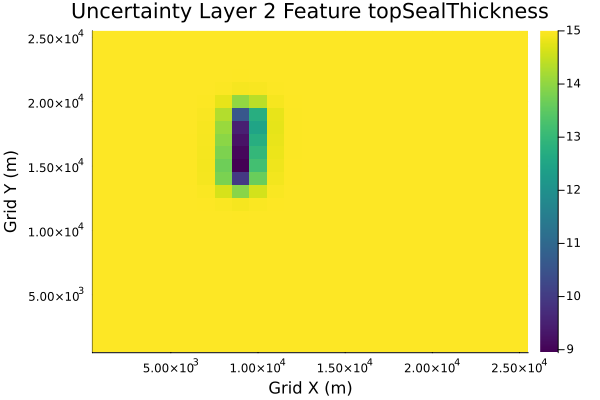

In [10]:
# Taking a seismic line action first
distr = POMDPs.observation(pomdp, all_actions[21], pomdp.state)
reward = POMDPs.reward(pomdp, pomdp.state, all_actions[21])
println(typeof(distr), "\nReward: ", reward)

visualize_uncertainty(pomdp, 2, FEATURE)

In [11]:
pomdp.rocktype_belief

5-element Vector{Categorical{Float64, Vector{Float64}}}:
 Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333])
 Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333])
 Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333])
 Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333])
 Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333])

In [12]:
distr = POMDPs.observation(pomdp, all_actions[2], pomdp.state);
pomdp.rocktype_belief

5-element Vector{Categorical{Float64, Vector{Float64}}}:
 Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.0, 0.0, 1.0])
 Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.0, 1.0, 0.0])
 Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[1.0, 0.0, 0.0])
 Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.0, 1.0, 0.0])
 Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.0, 0.0, 1.0])

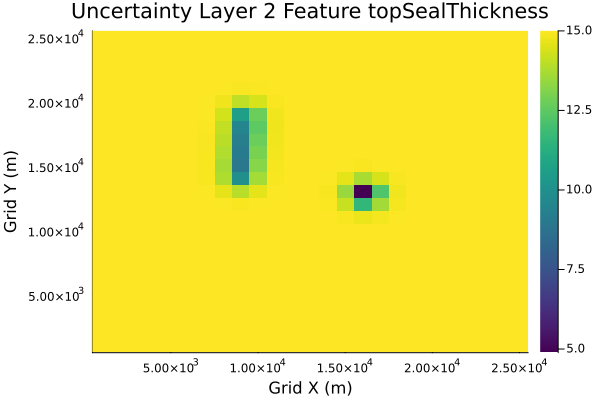

In [13]:
visualize_uncertainty(pomdp, 2, FEATURE)

Distributions.ProductDistribution{2, 1, Vector{MixtureModel{Multivariate, Continuous, MvNormal, Categorical{Float64, Vector{Float64}}}}, Continuous, Float64}
Reward: 19.810287063630227


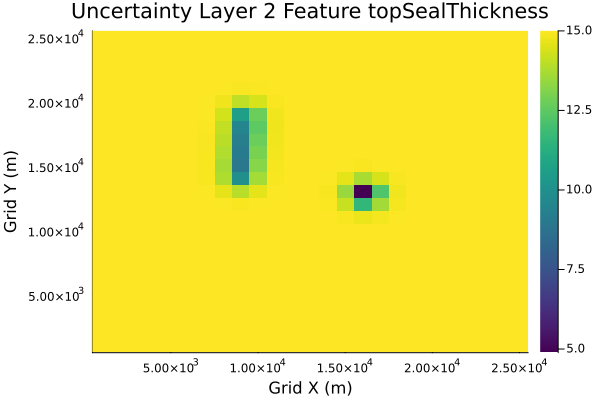

In [14]:
reward = POMDPs.reward(pomdp, pomdp.state, all_actions[2])
println(typeof(distr), "\nReward: ", reward)

visualize_uncertainty(pomdp, 2, FEATURE)

Distributions.ProductDistribution{2, 1, Vector{MixtureModel{Multivariate, Continuous, MvNormal, Categorical{Float64, Vector{Float64}}}}, Continuous, Float64}
Reward: -3.5223321252854873


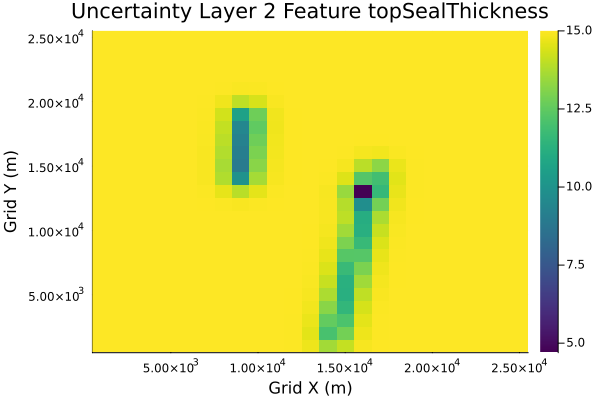

In [15]:
# Timing test for seismic line observation and reward function
distr = POMDPs.observation(pomdp, all_actions[19], pomdp.state)
reward = POMDPs.reward(pomdp, pomdp.state, all_actions[19])
println(typeof(distr), "\nReward: ", reward)
visualize_uncertainty(pomdp, 2, FEATURE)

Distributions.ProductDistribution{2, 1, Vector{MixtureModel{Multivariate, Continuous, MvNormal, Categorical{Float64, Vector{Float64}}}}, Continuous, Float64}
Reward: -2.701378671732229


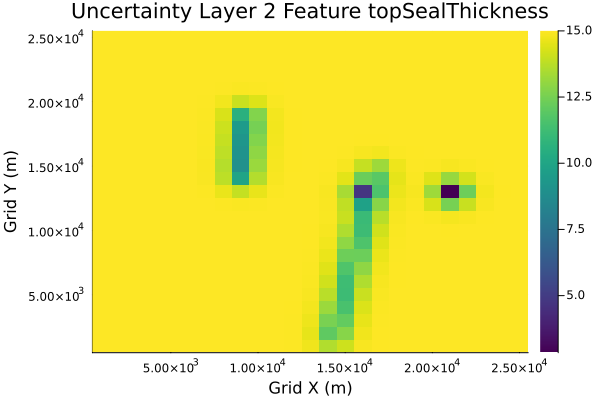

In [16]:
# Timing test for well log observation and reward function
distr = POMDPs.observation(pomdp, all_actions[1], pomdp.state)
reward = POMDPs.reward(pomdp, pomdp.state, all_actions[1])
println(typeof(distr), "\nReward: ", reward)
visualize_uncertainty(pomdp, 2, FEATURE)